In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pickle

ALL_FILES = [
    "2950_spike_mat_or_rand",
    "2953_spike_mat_or_rand",
    "2957_spike_mat_or_rand",
    "5116_spike_mat_or_rand",
    # Add more files if necessary
    # "231023_22426_112_t_spk_mat_sorted",
    # "231023_22426_113_t_spk_mat_sorted",
    # "231023_22465_101_t_spk_mat_sorted",
    # "231023_22465_102_t_spk_mat_sorted",
]

[[0.41429467 0.11762718 0.69712056]
 [0.11762718 0.03410085 0.1944955 ]
 [0.69712056 0.1944955  1.19383862]]


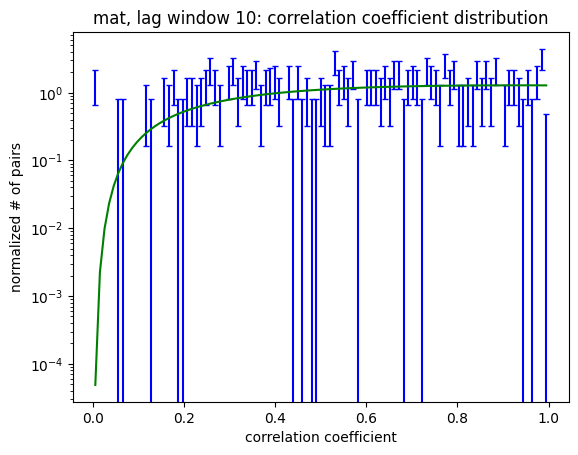

Optimal parameters not found: Number of calls to function has reached maxfev = 800.


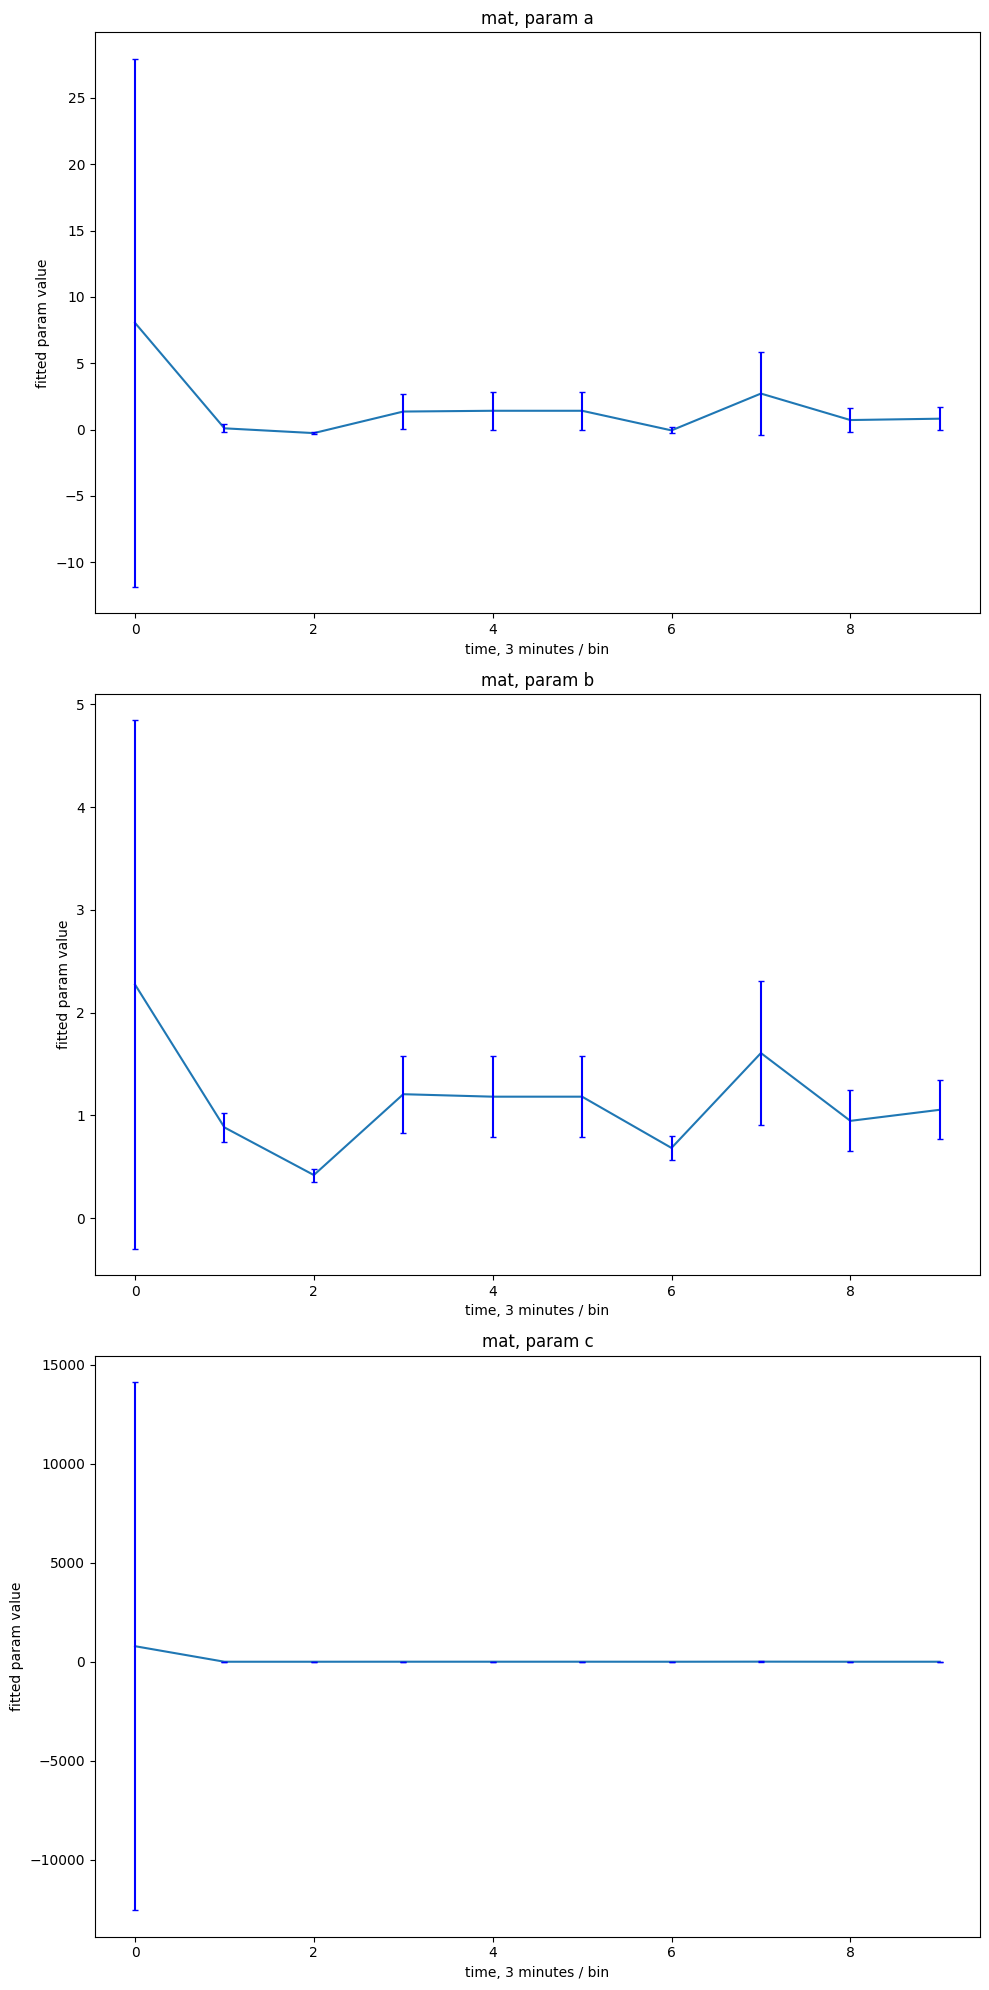

0.99995


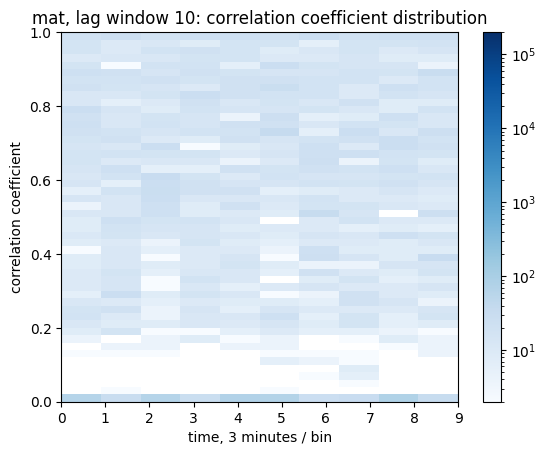

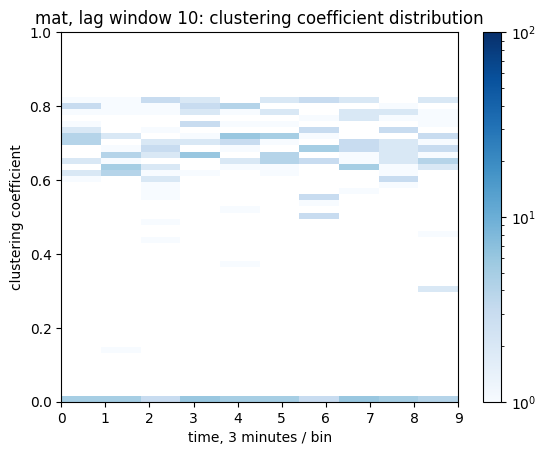

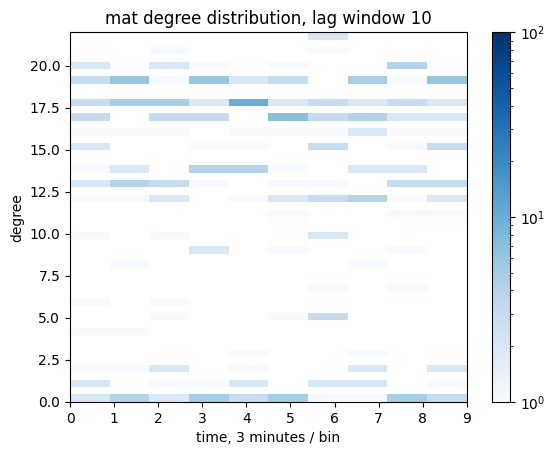

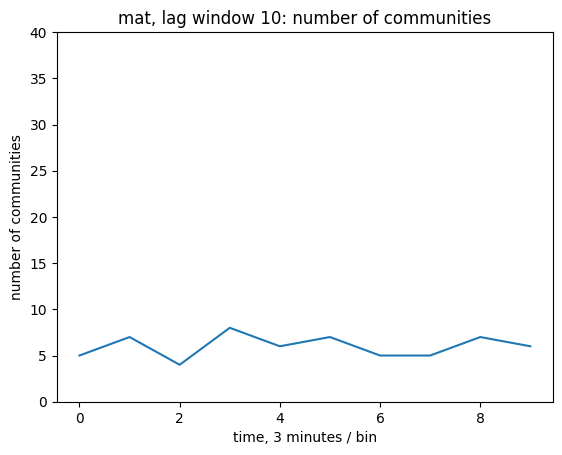

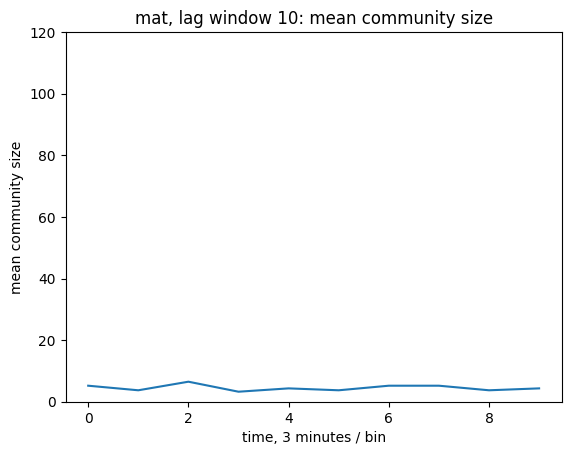

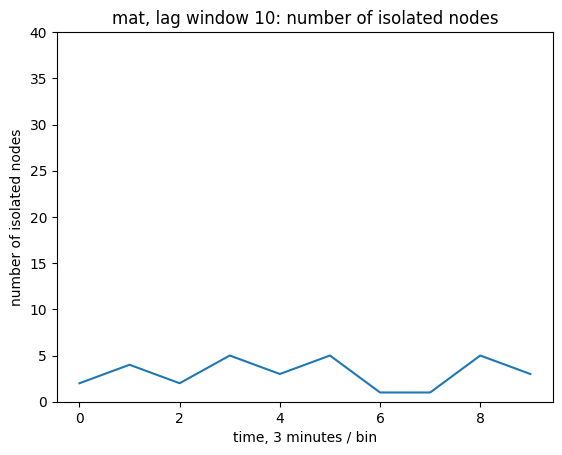

[[ 1.25711529e-03  7.09759780e-04  5.14356588e-05]
 [ 7.09759780e-04  7.02035925e-04 -7.40151782e-05]
 [ 5.14356588e-05 -7.40151782e-05  1.06955252e-04]]


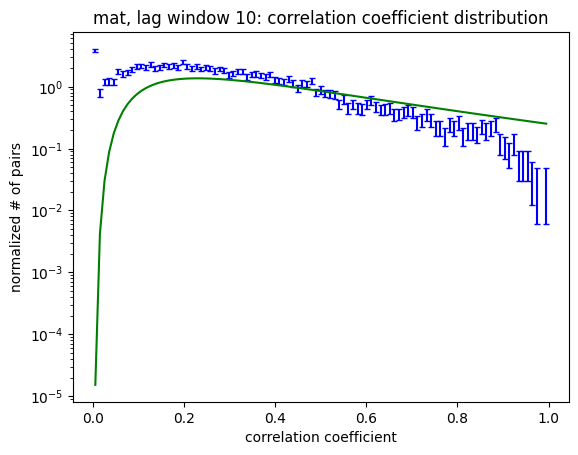

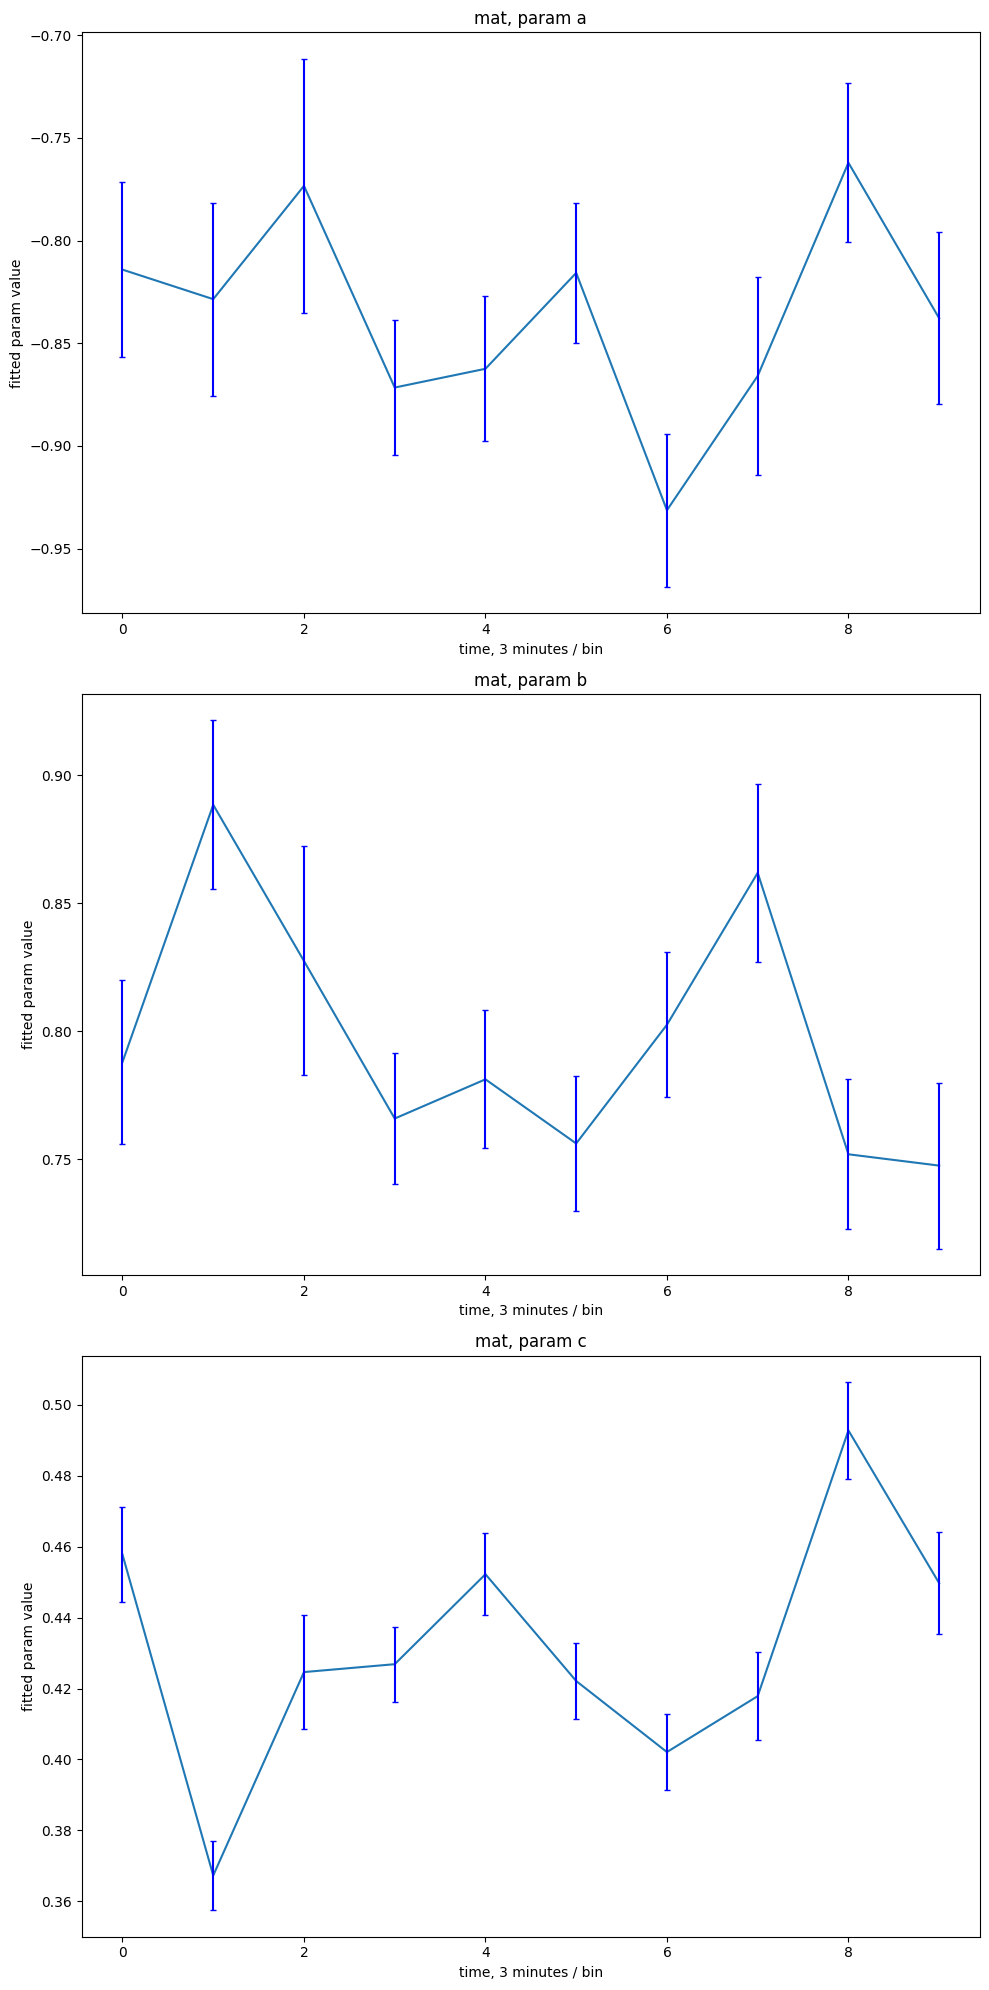

1.0000002


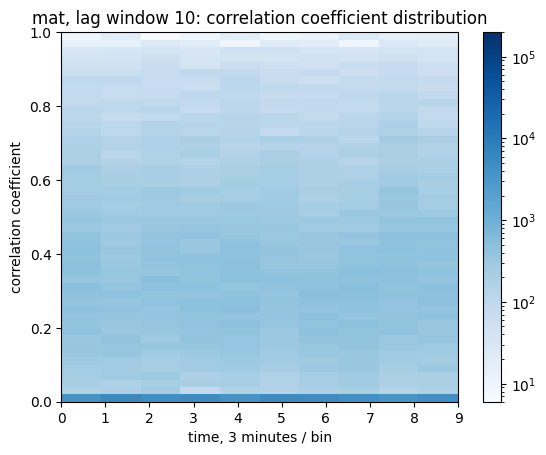

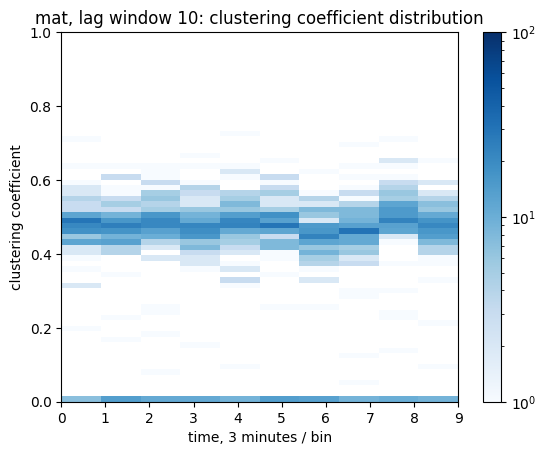

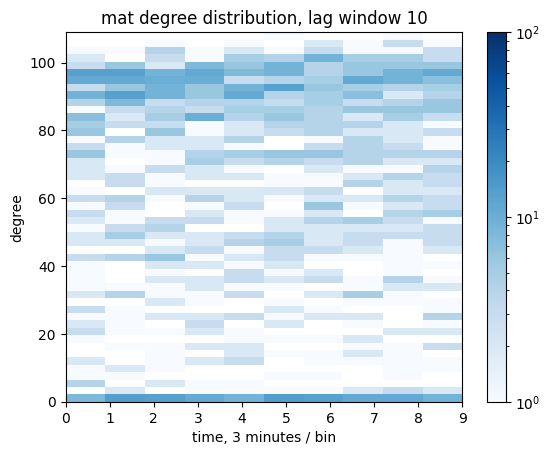

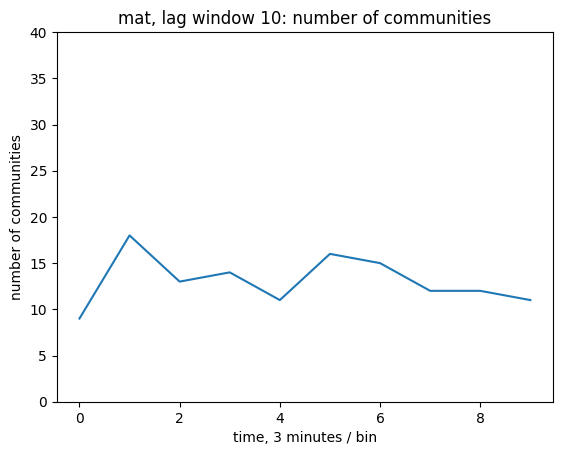

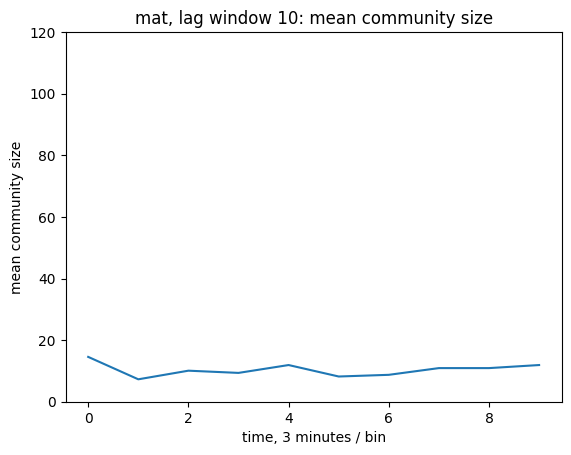

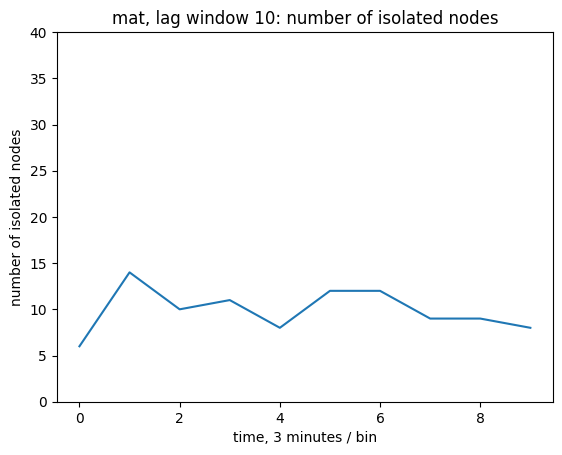

[[ 5.91228201e-04  3.74185770e-04 -6.49736085e-05]
 [ 3.74185770e-04  4.86667513e-04 -5.44751561e-04]
 [-6.49736085e-05 -5.44751561e-04  3.37186616e-03]]


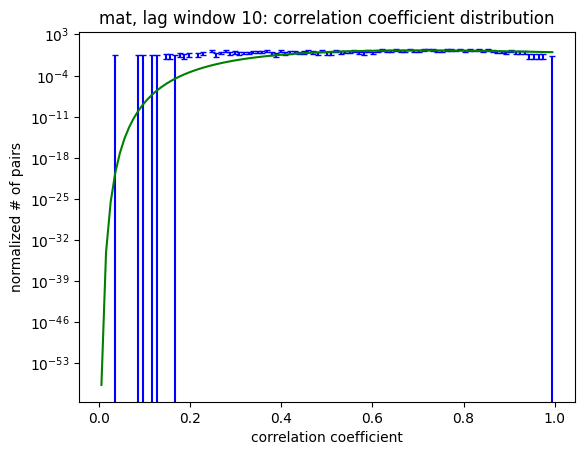

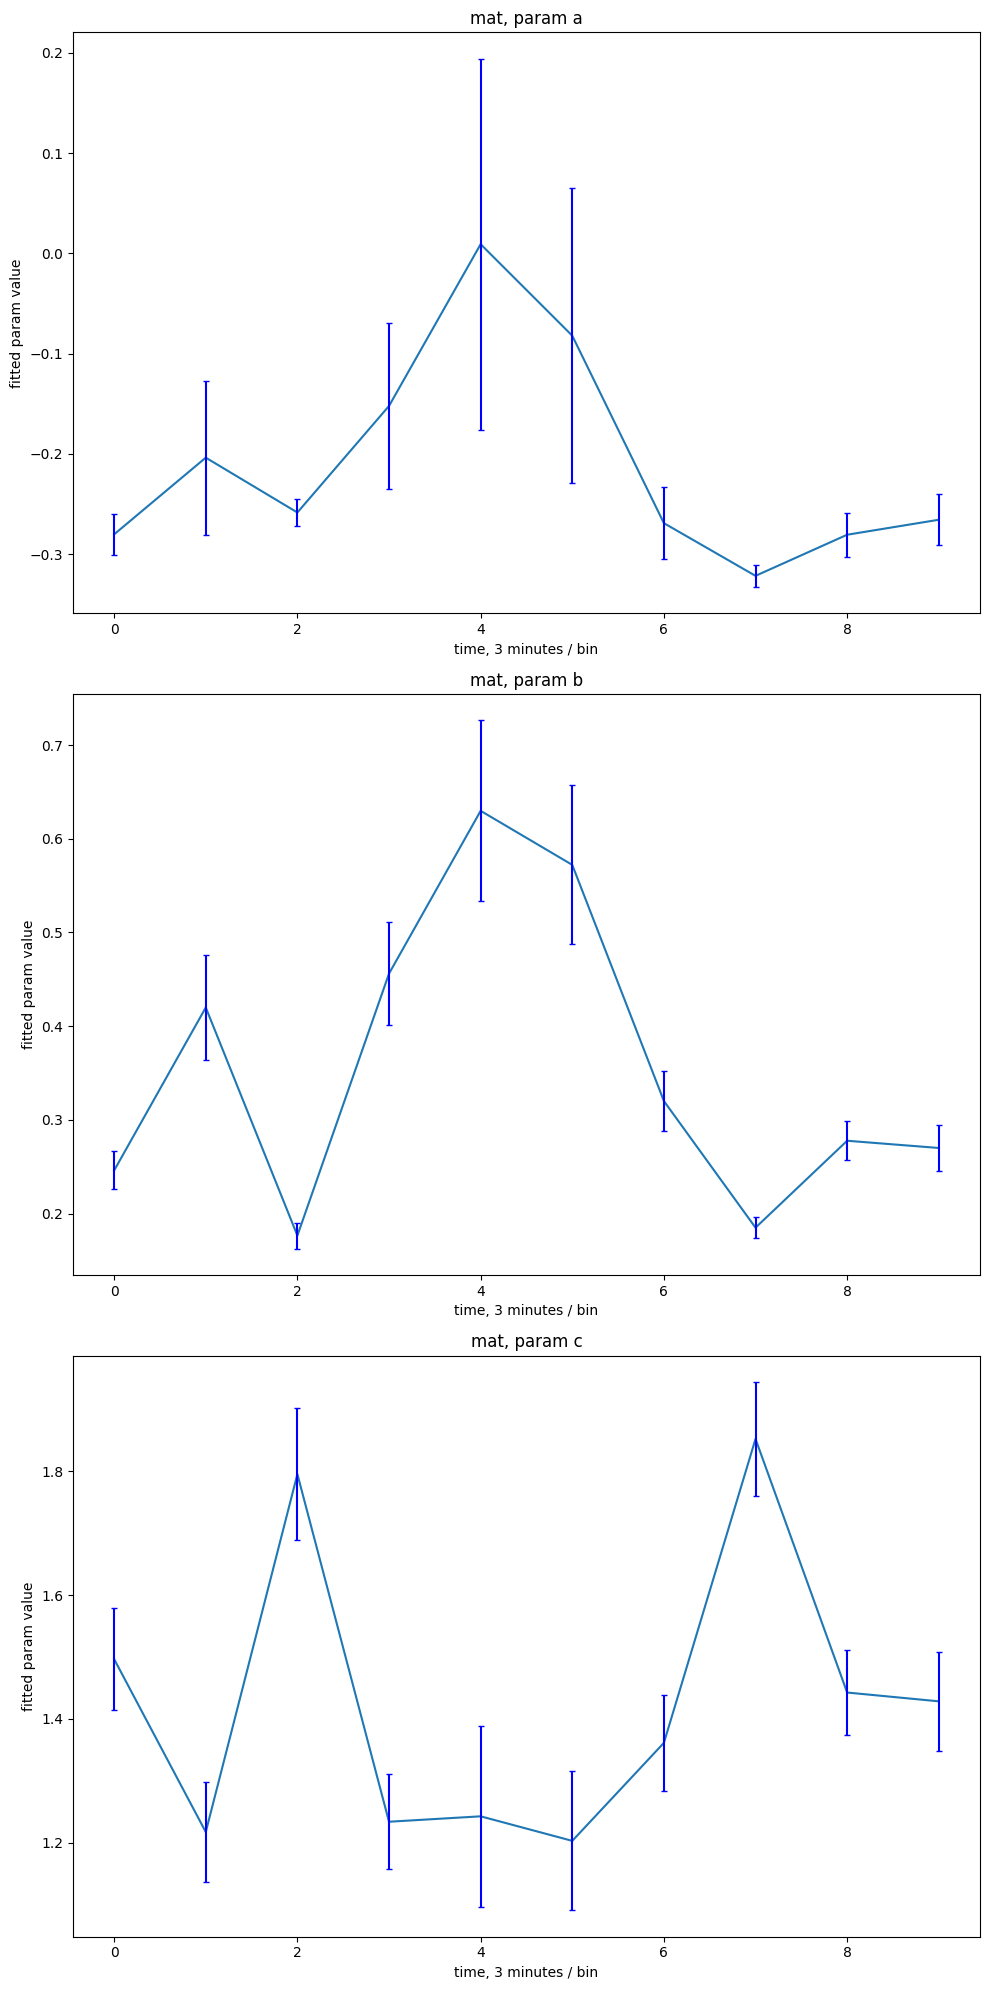

0.99848163


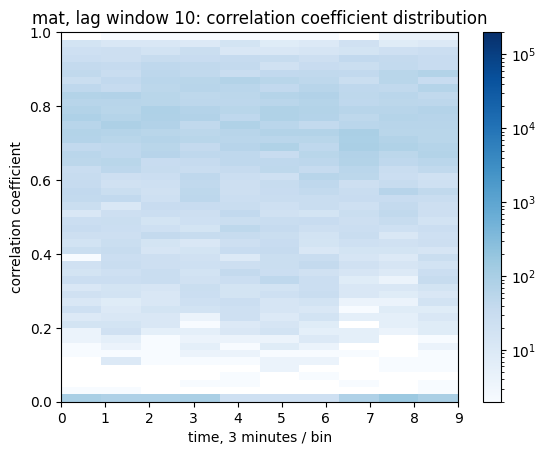

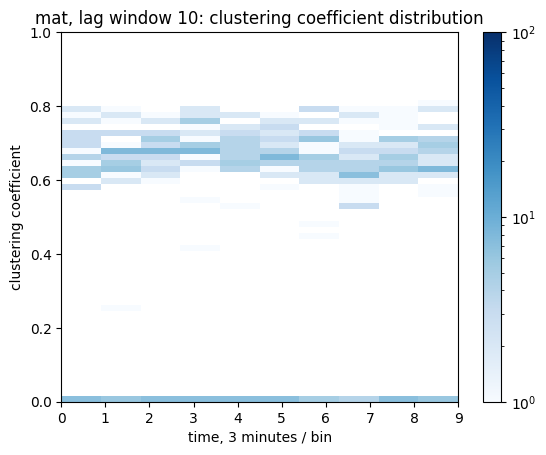

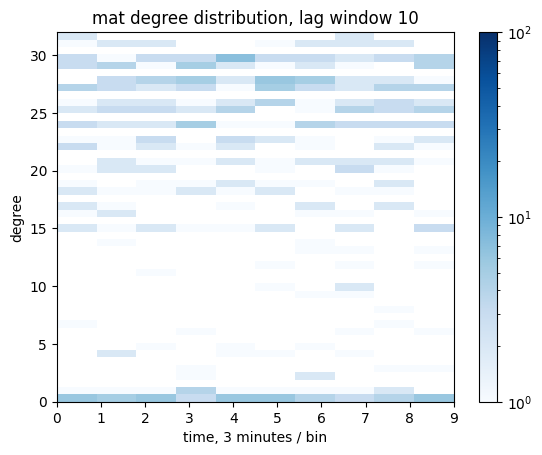

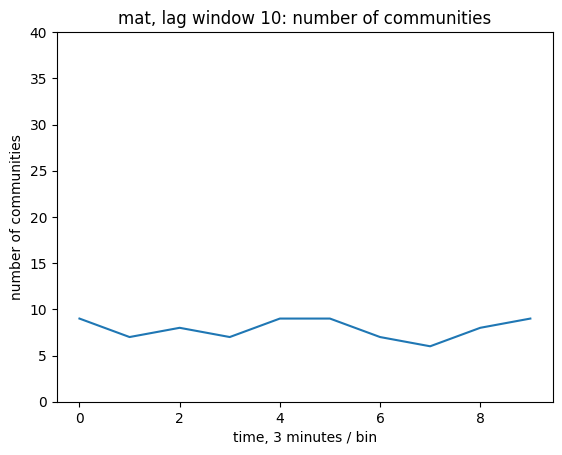

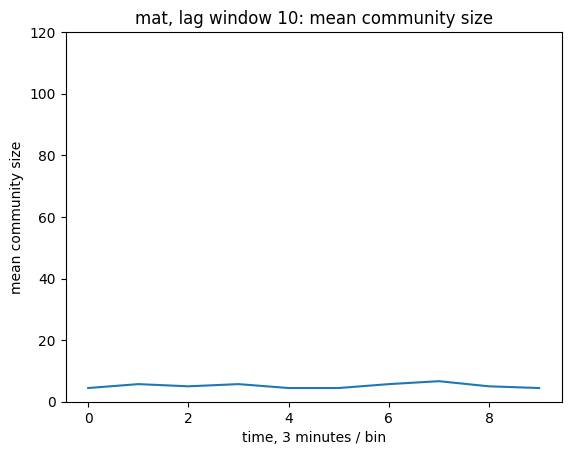

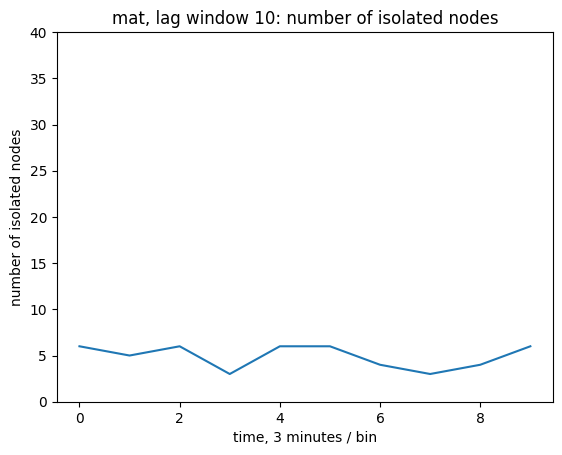

[[ 1.28929120e-03  7.54145090e-04  4.07228103e-05]
 [ 7.54145090e-04  8.07372830e-04 -1.24924157e-04]
 [ 4.07228103e-05 -1.24924157e-04  1.87365720e-04]]


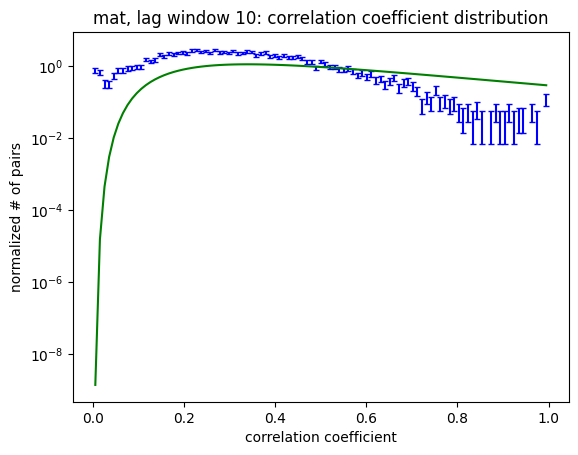

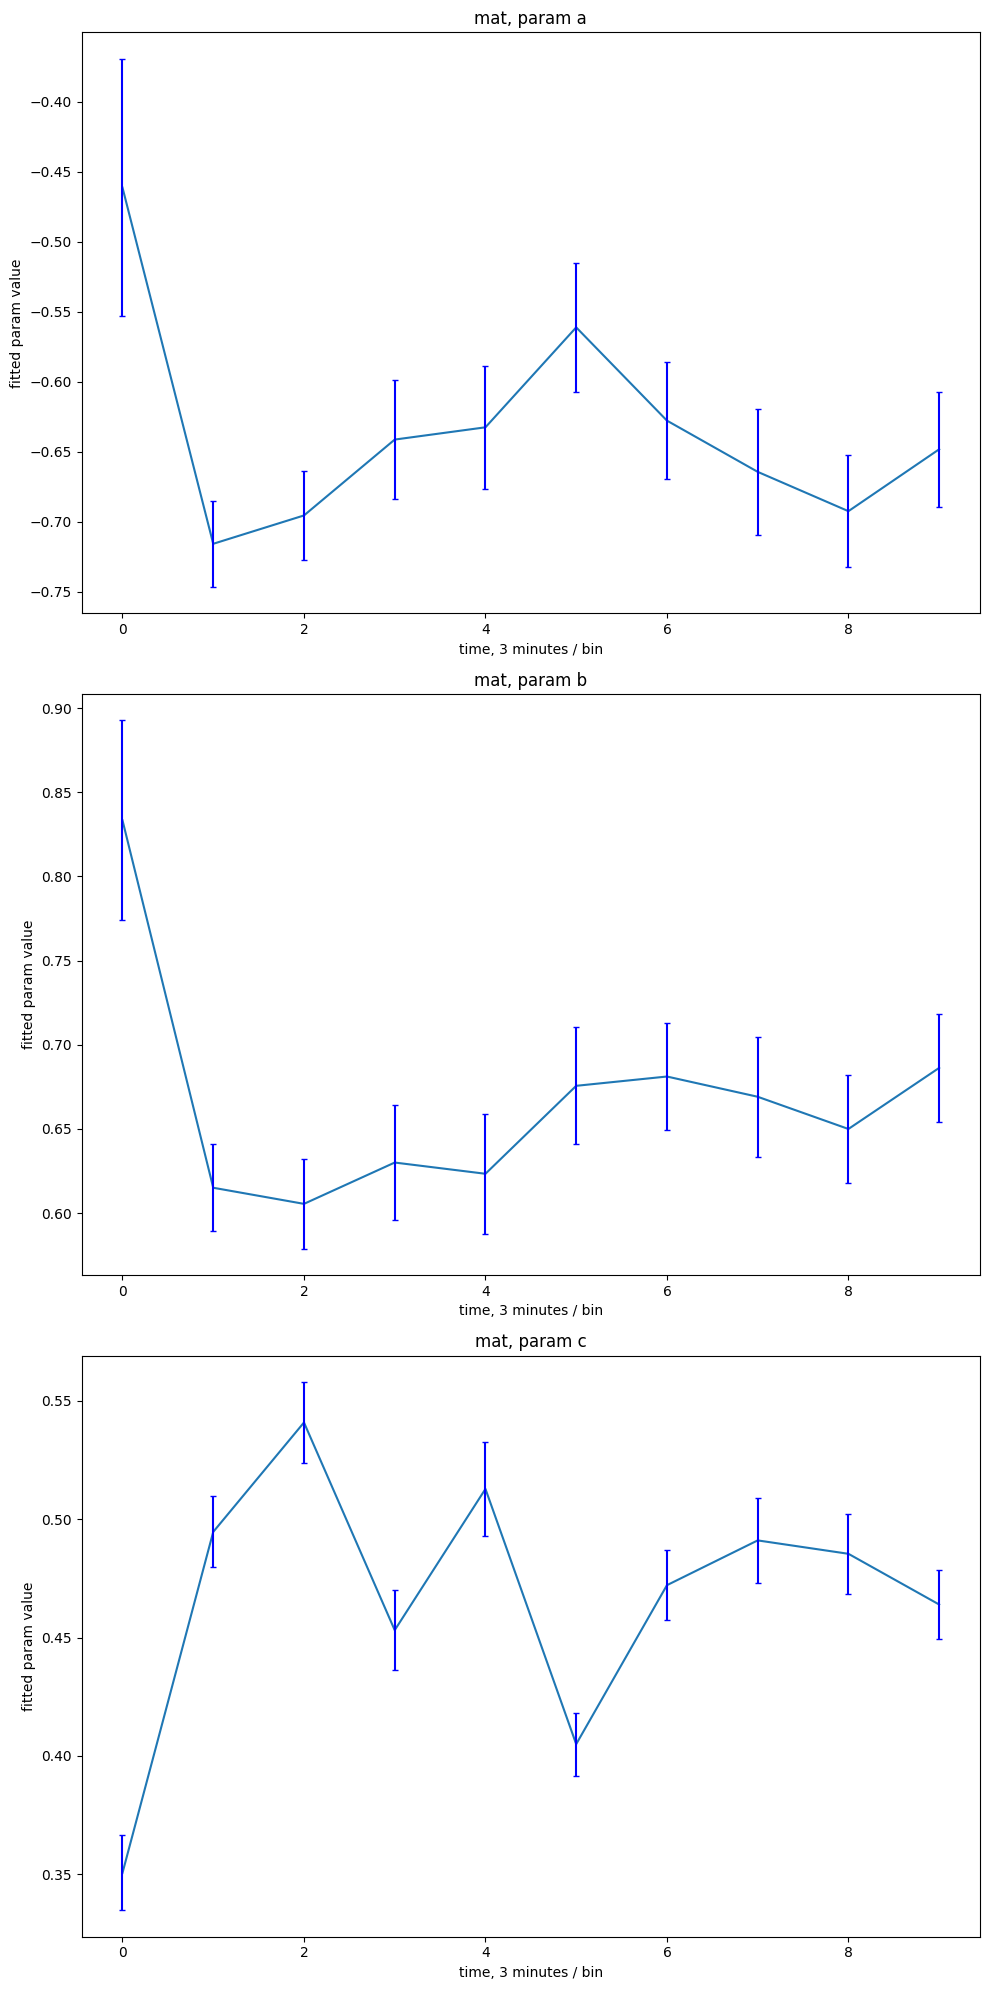

1.0000002


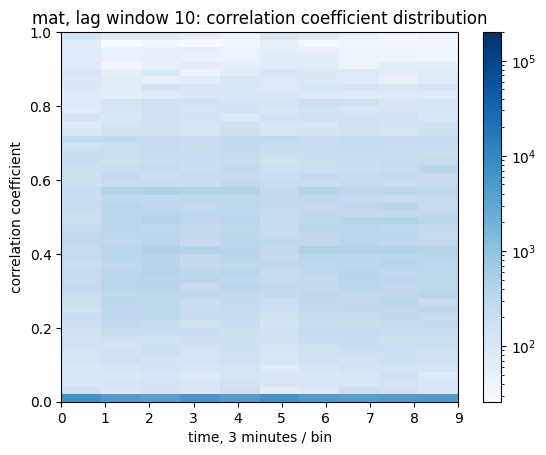

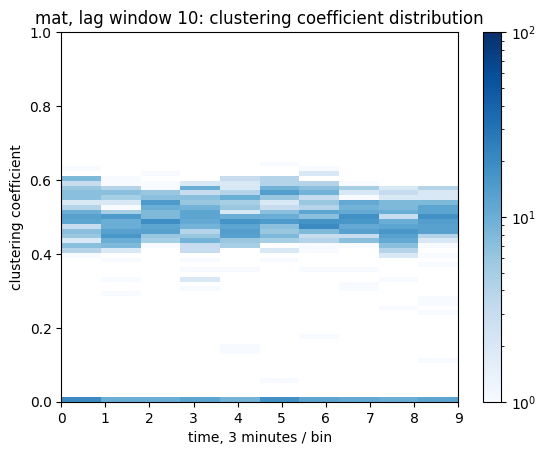

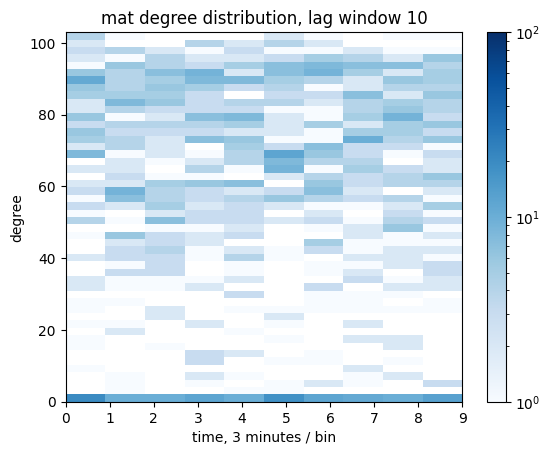

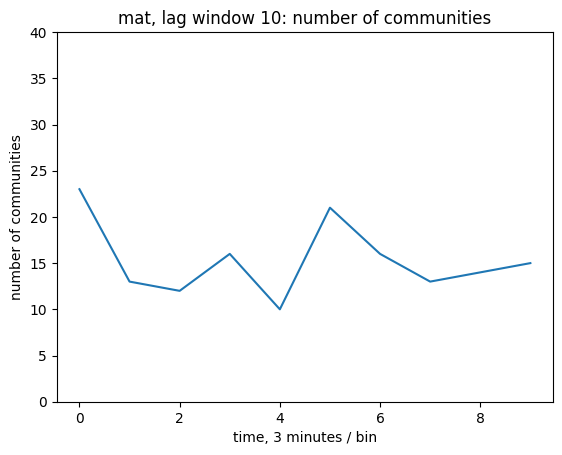

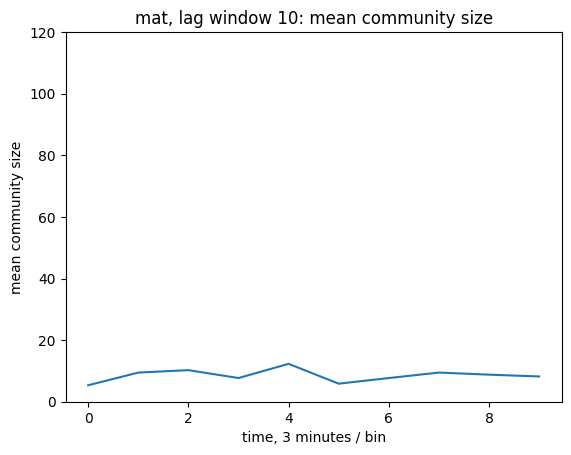

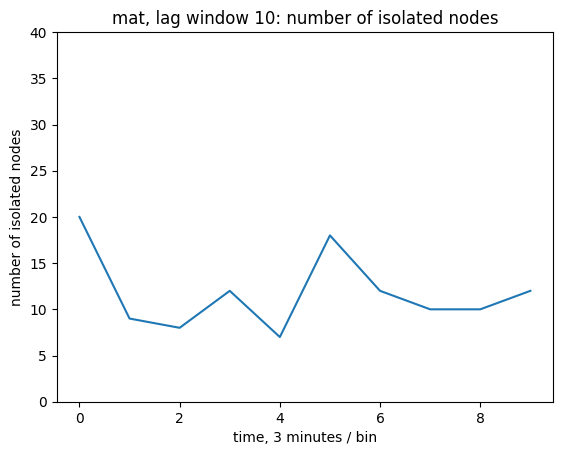

[[6.27079101e+00 1.17574363e+00 8.61973742e+01]
 [1.17574363e+00 2.21642587e-01 1.60847078e+01]
 [8.61973742e+01 1.60847078e+01 1.19001181e+03]]


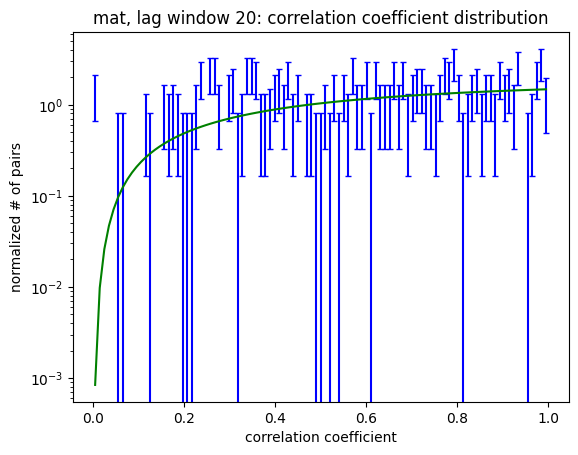

Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Optimal parameters not found: Number of calls to function has reached maxfev = 800.


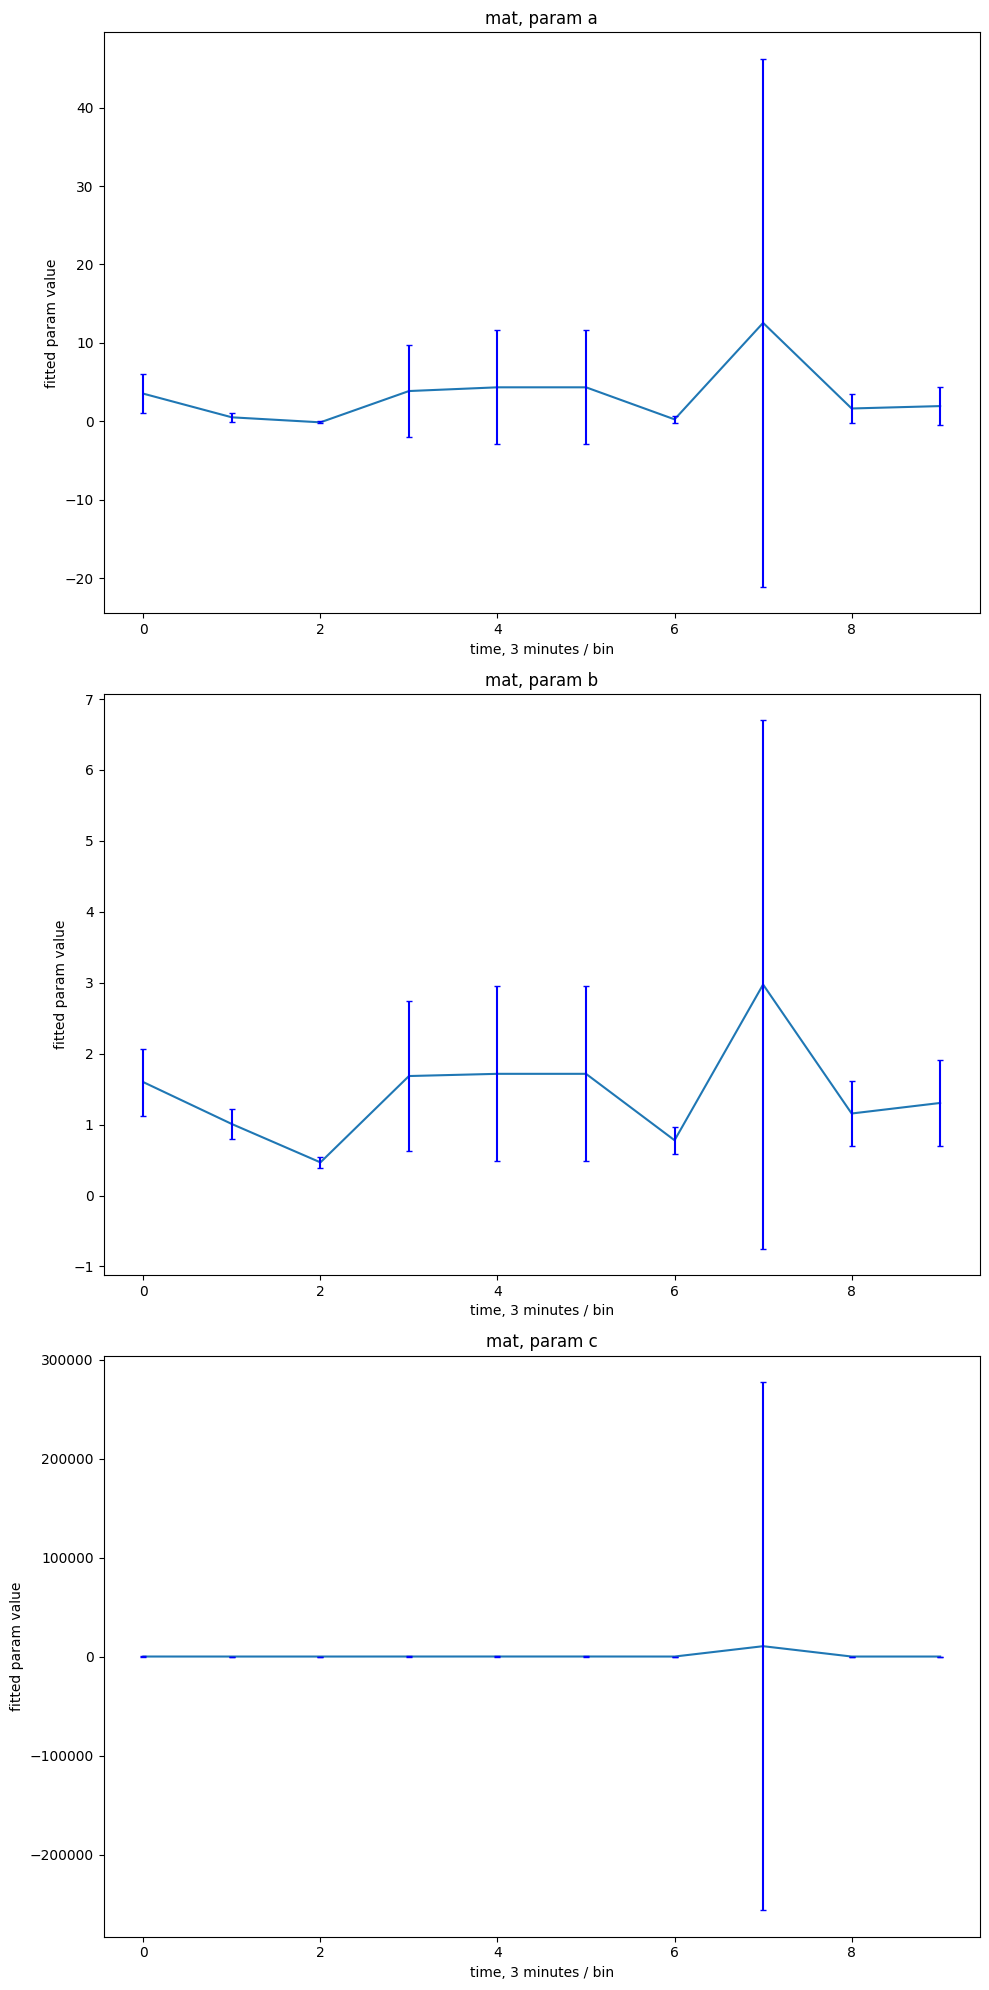

0.99995


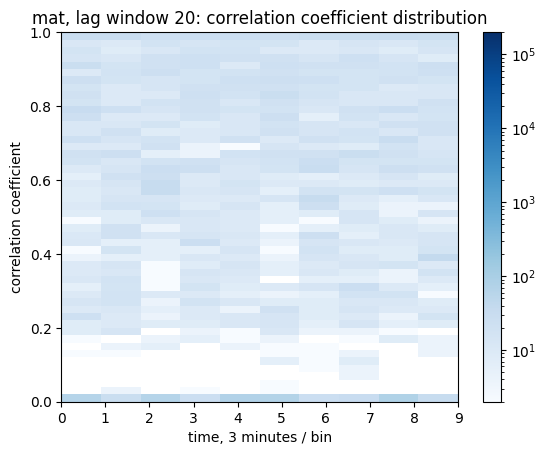

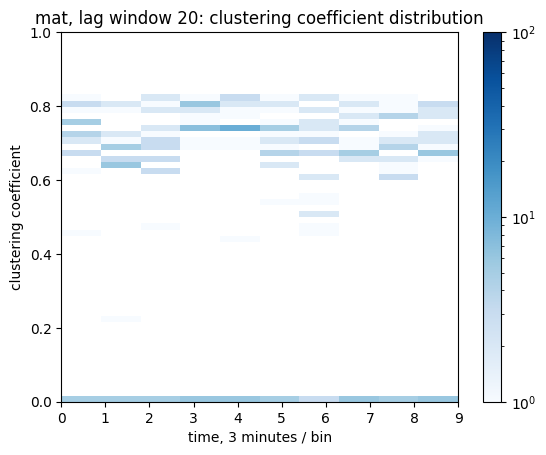

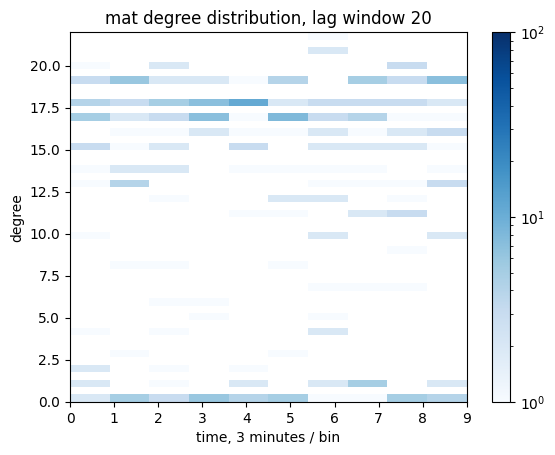

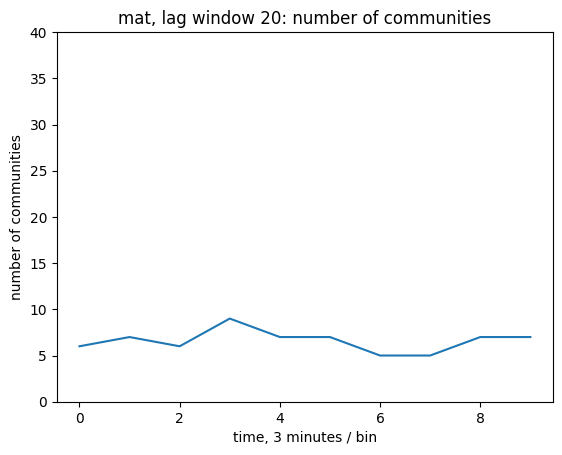

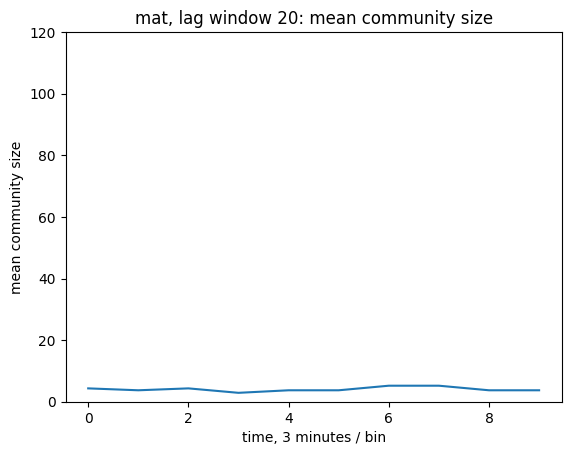

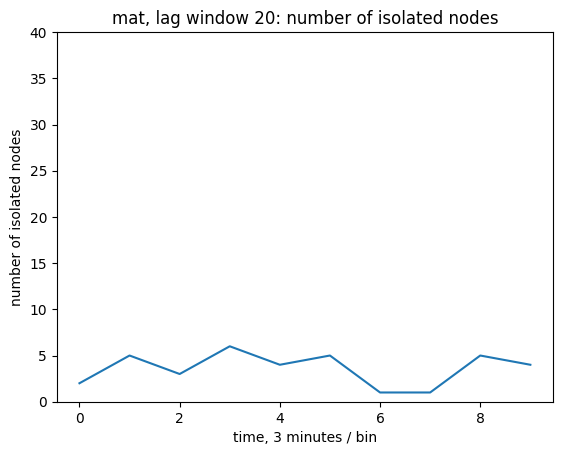

[[ 1.12548914e-03  6.38674926e-04  4.51854414e-05]
 [ 6.38674926e-04  6.41771362e-04 -7.41210567e-05]
 [ 4.51854414e-05 -7.41210567e-05  1.08345430e-04]]


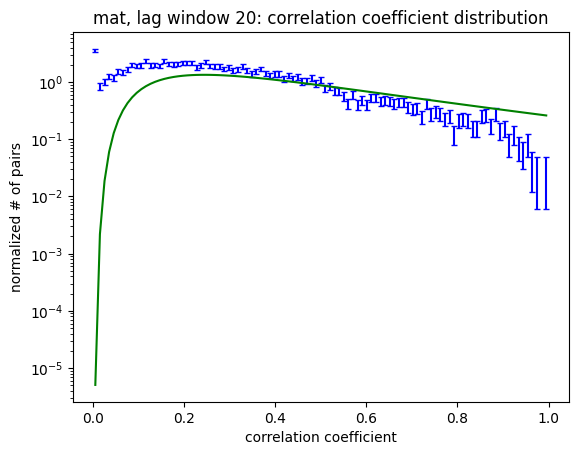

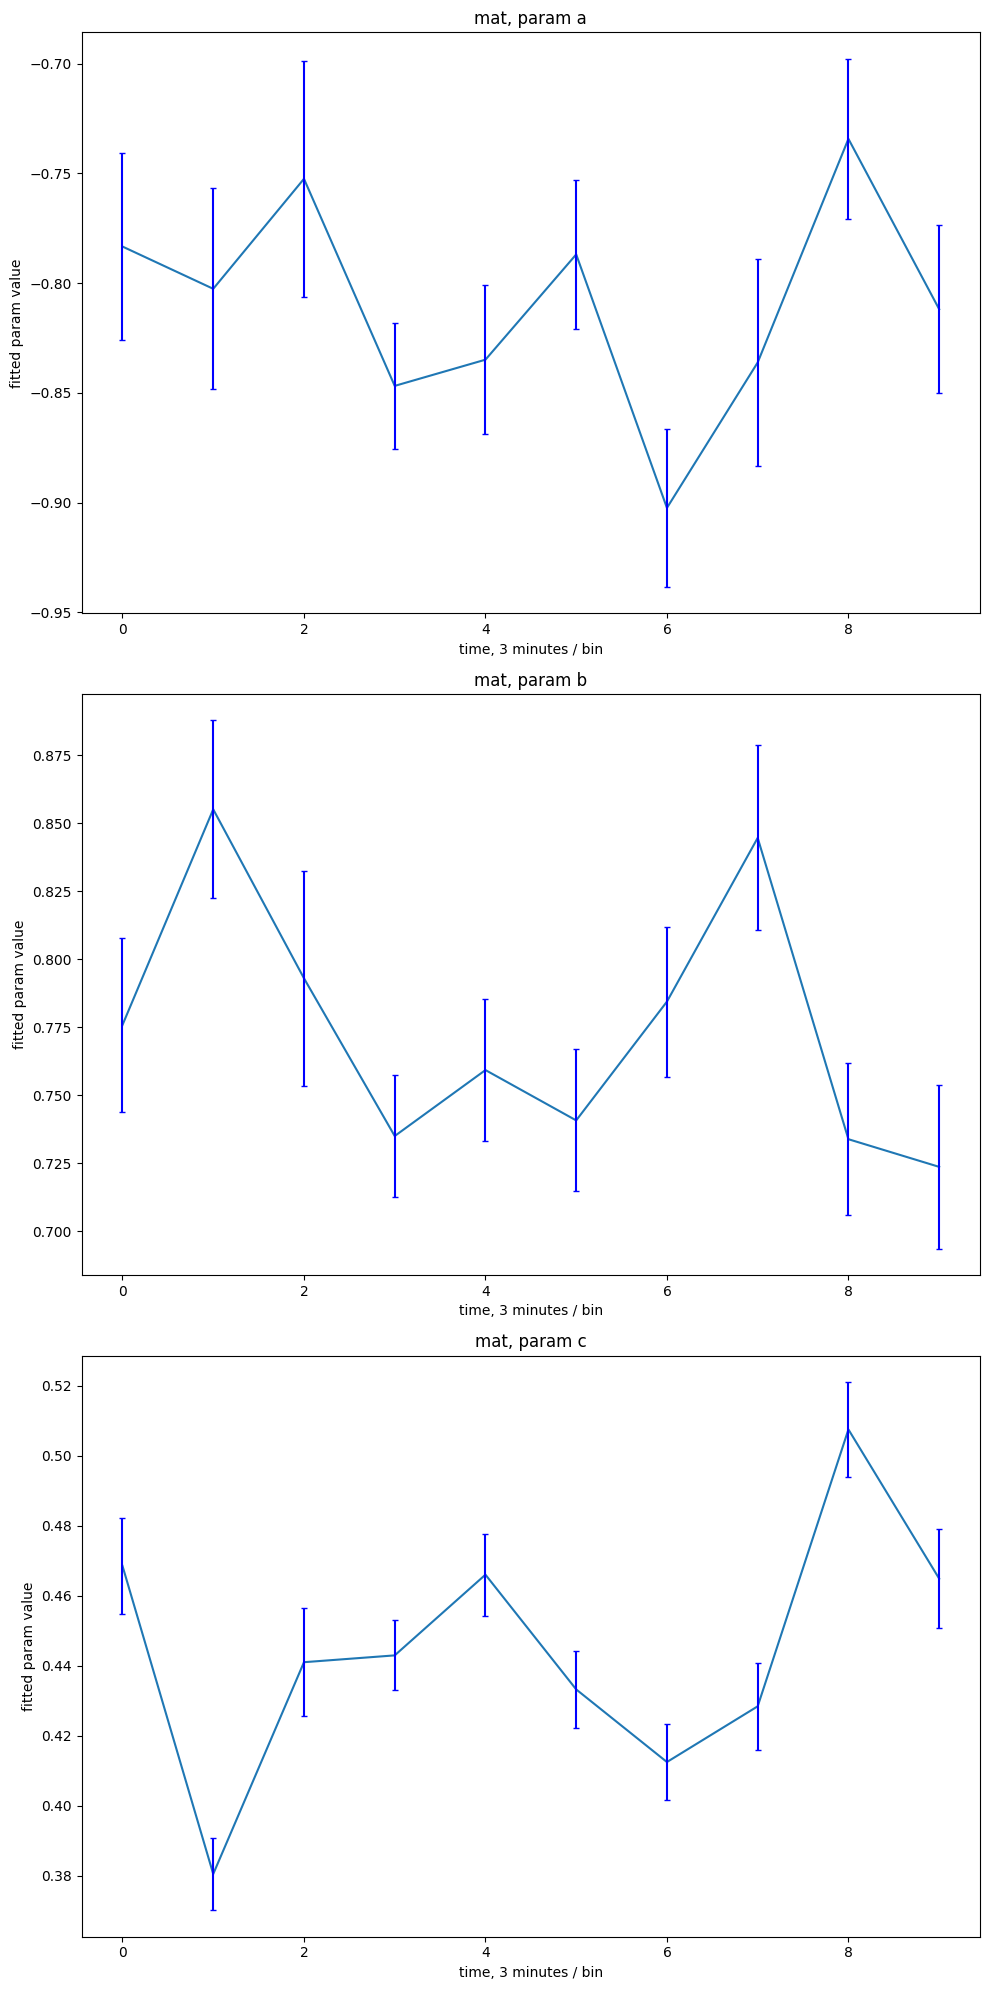

1.0000002


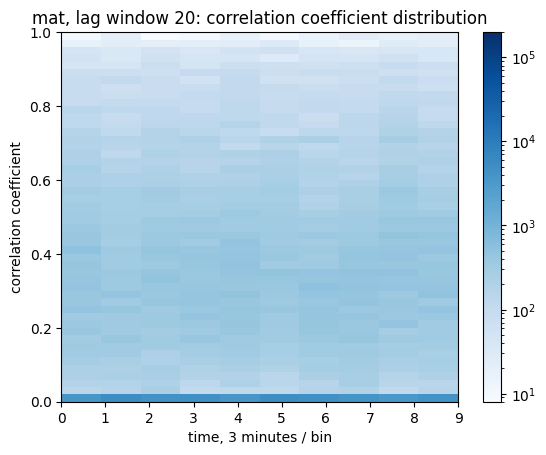

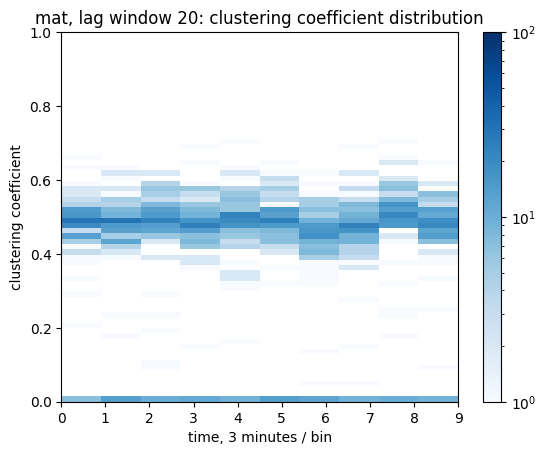

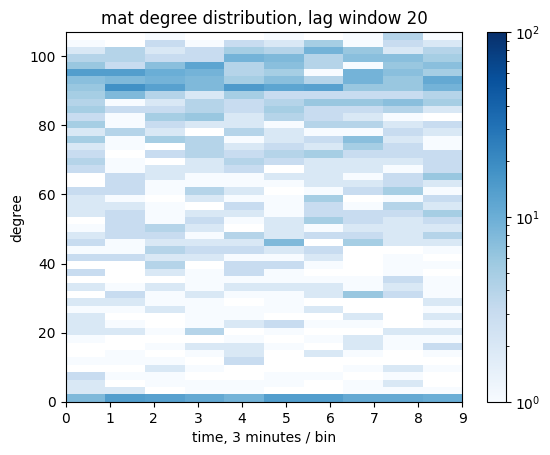

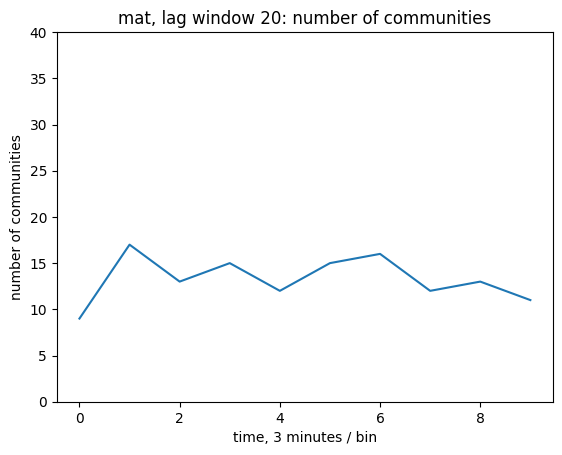

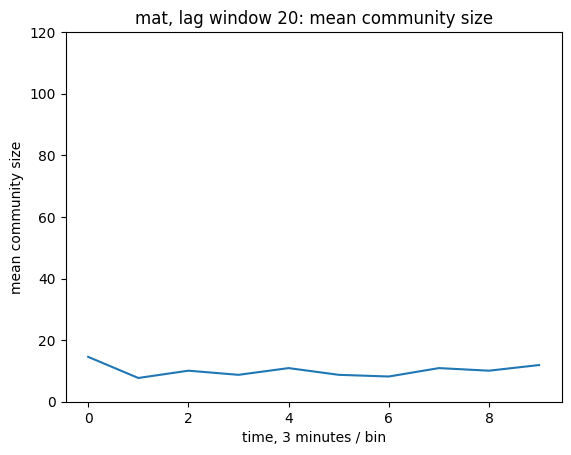

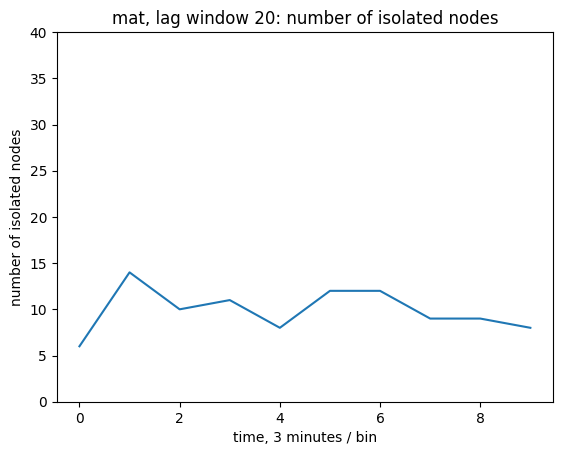

[[ 0.00037344  0.00022996 -0.00010376]
 [ 0.00022996  0.00033632 -0.00056263]
 [-0.00010376 -0.00056263  0.00416364]]


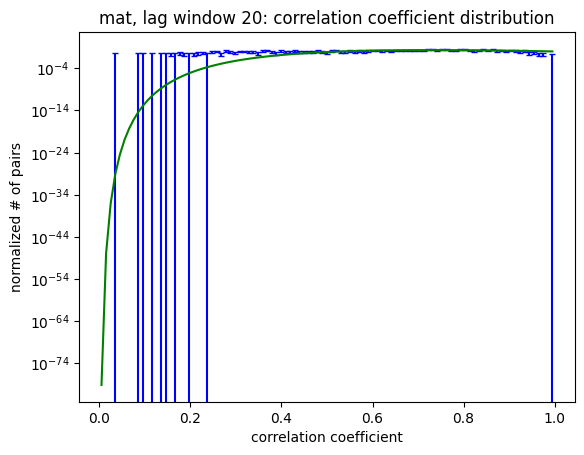

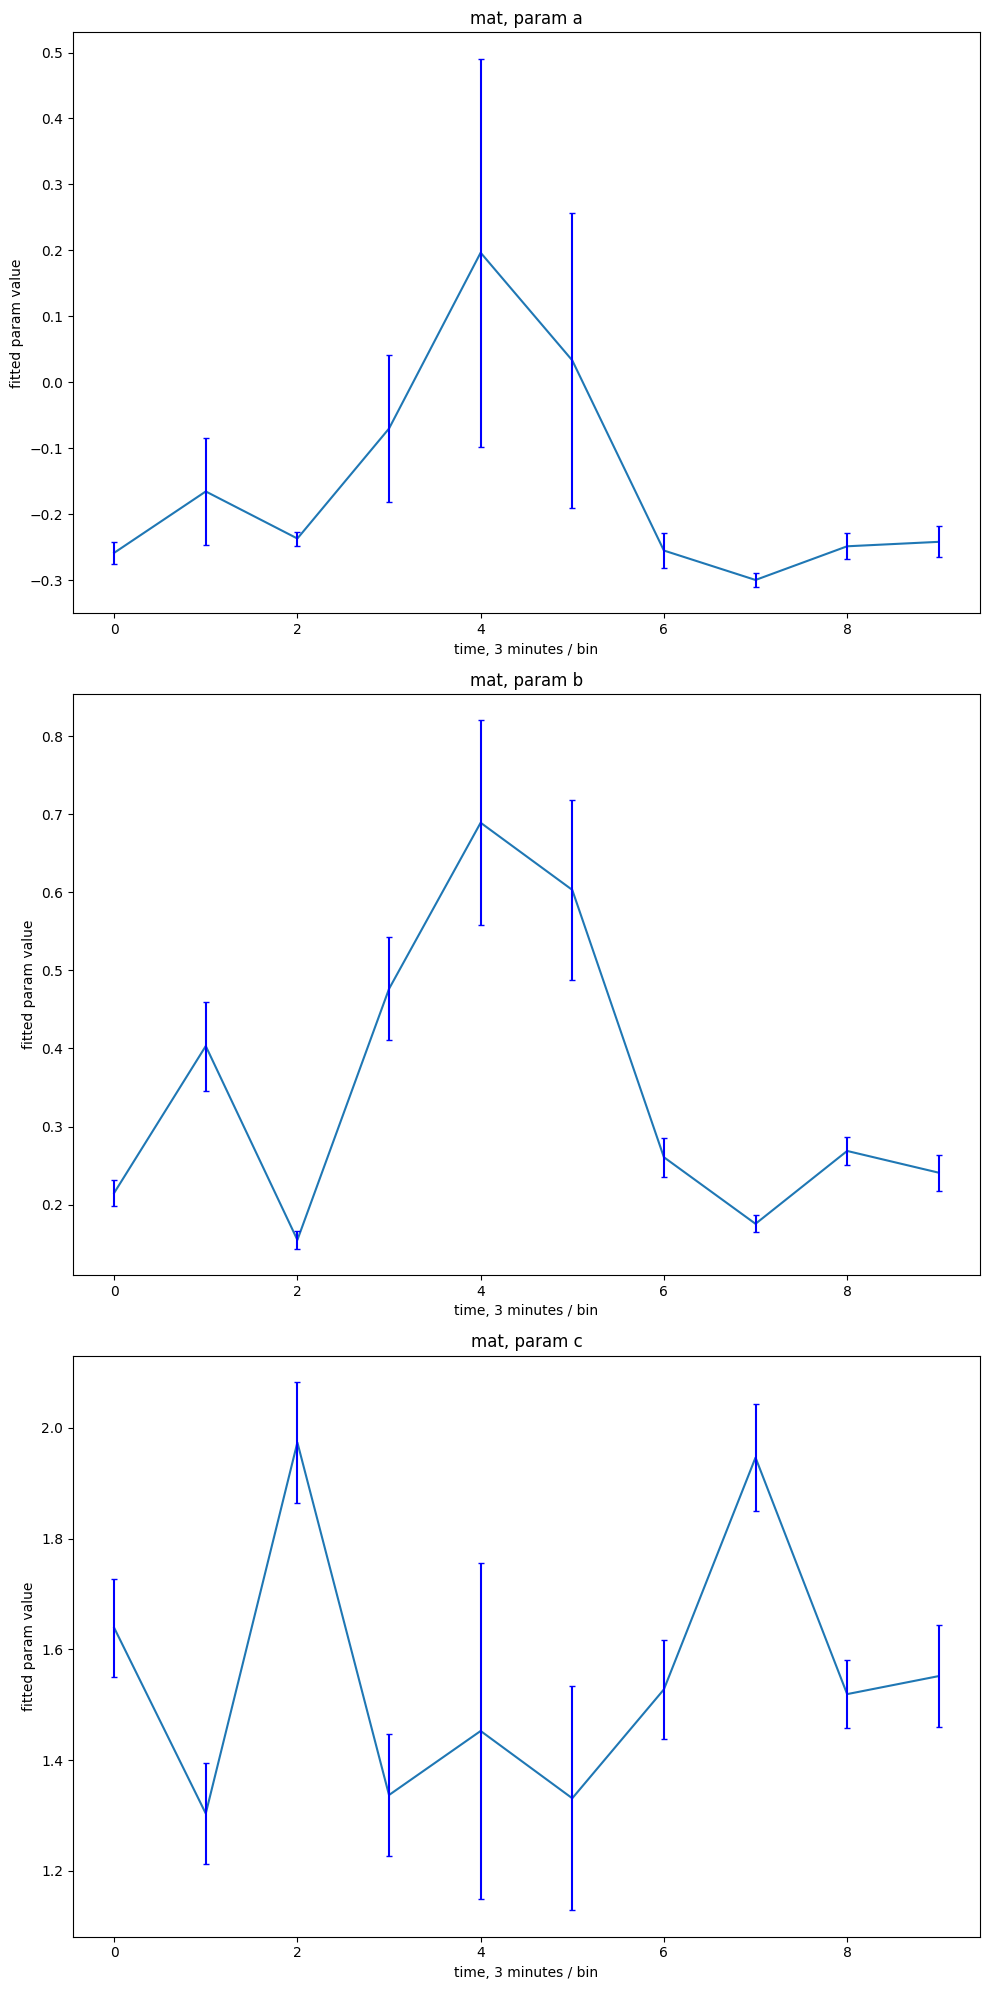

0.99848163


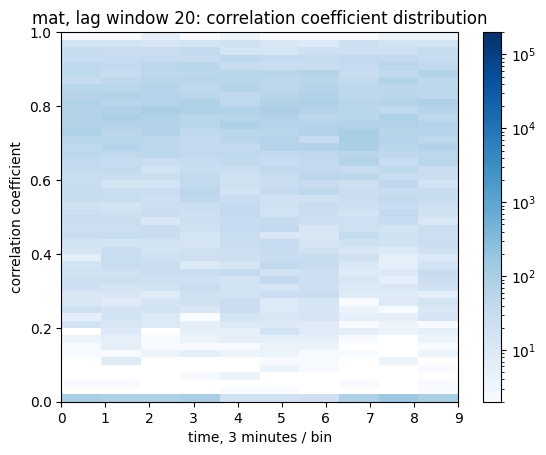

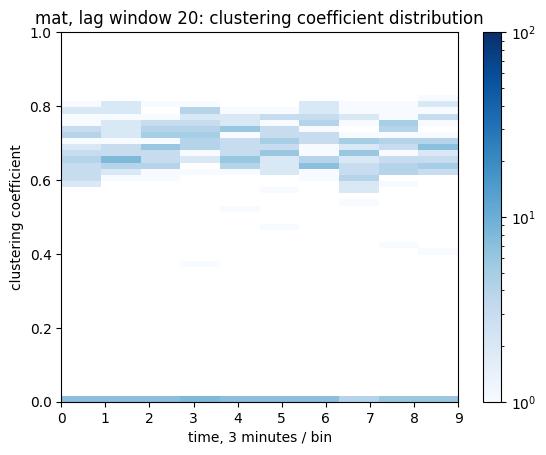

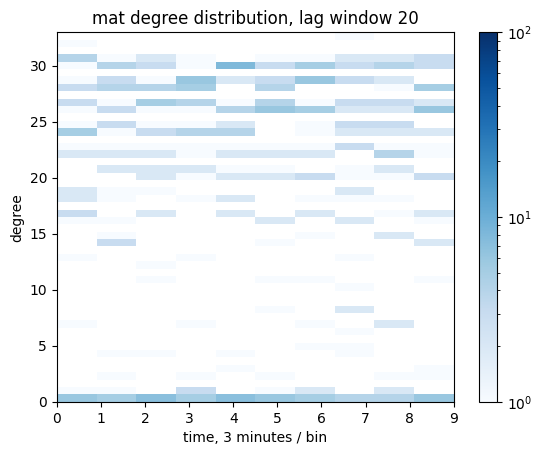

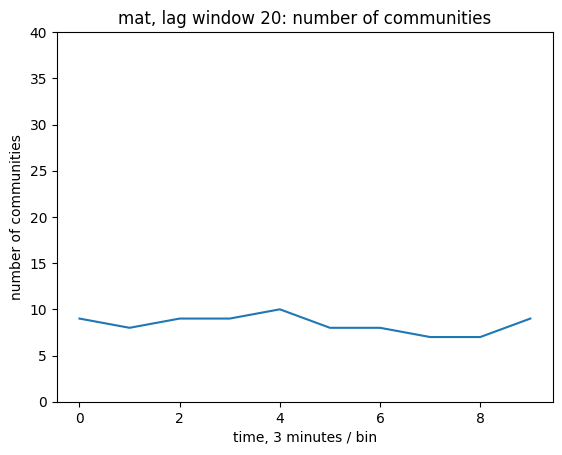

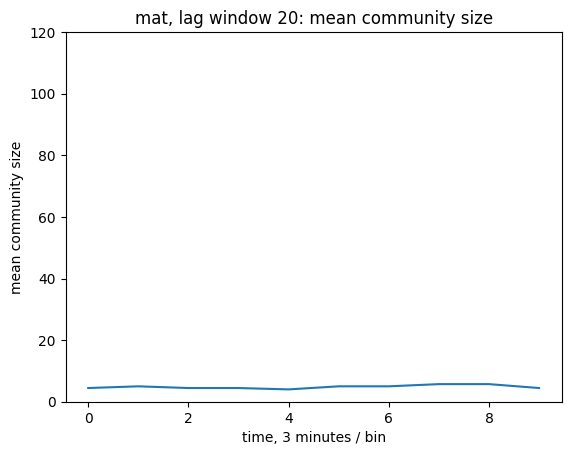

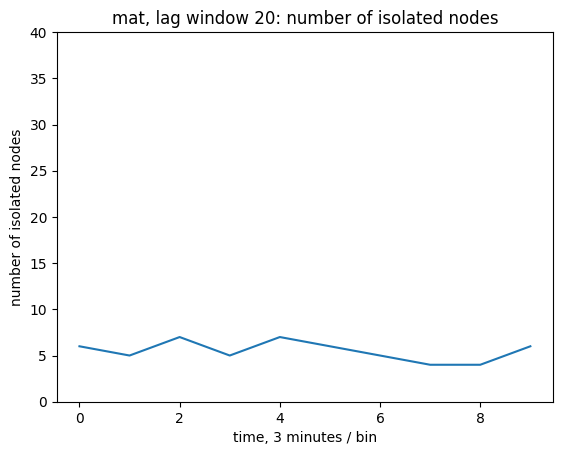

[[ 1.28174459e-03  7.55601213e-04  3.67033971e-05]
 [ 7.55601213e-04  8.29254930e-04 -1.49285853e-04]
 [ 3.67033971e-05 -1.49285853e-04  2.37306828e-04]]


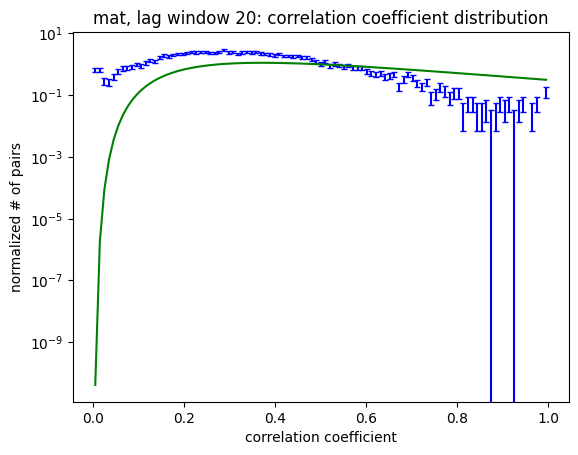

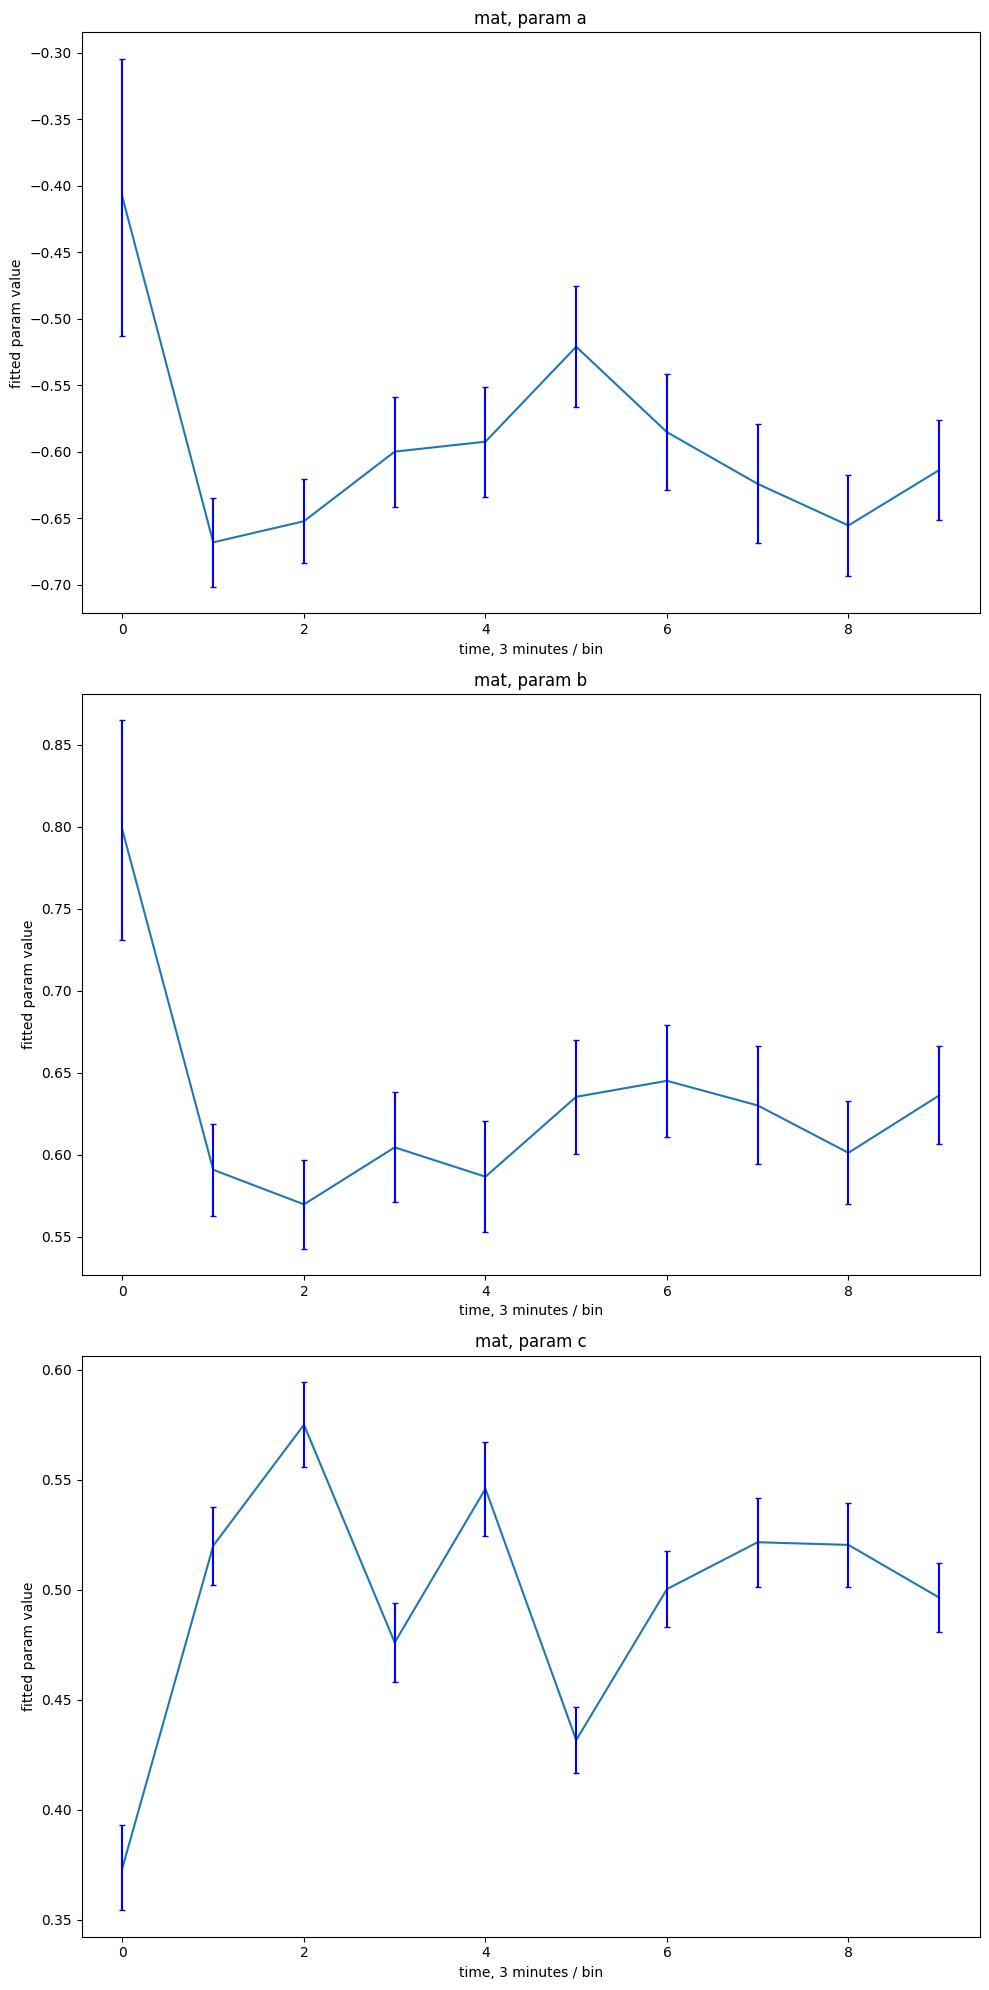

1.0000002


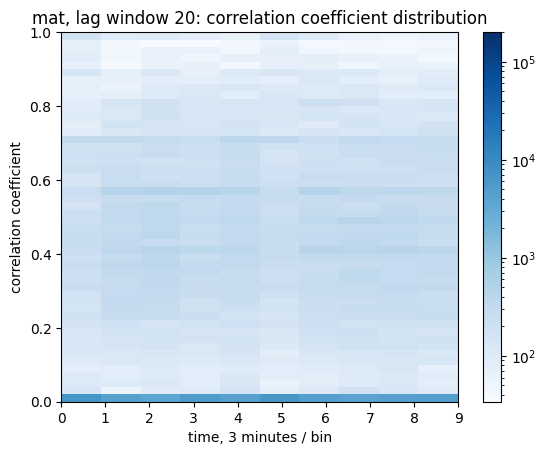

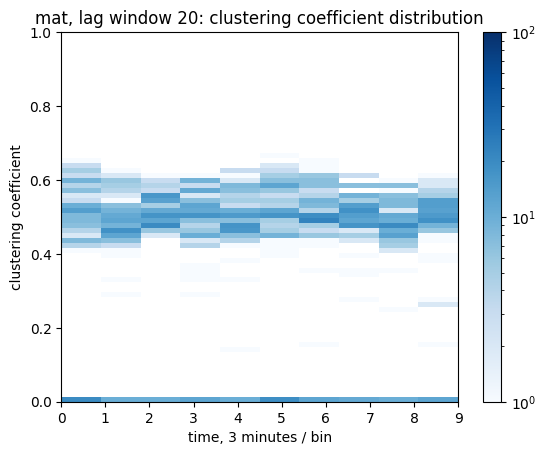

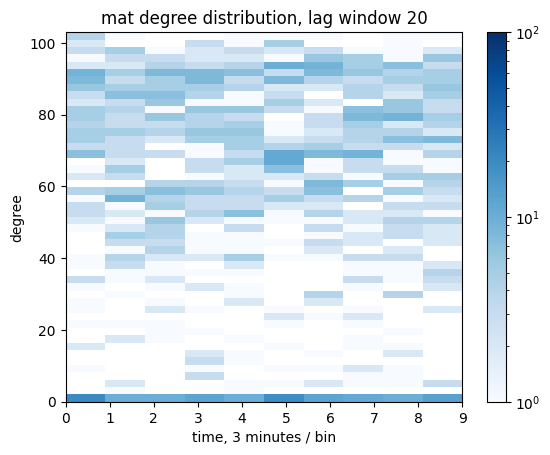

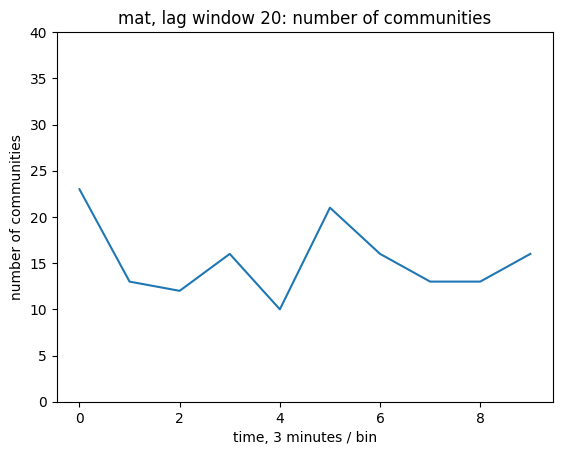

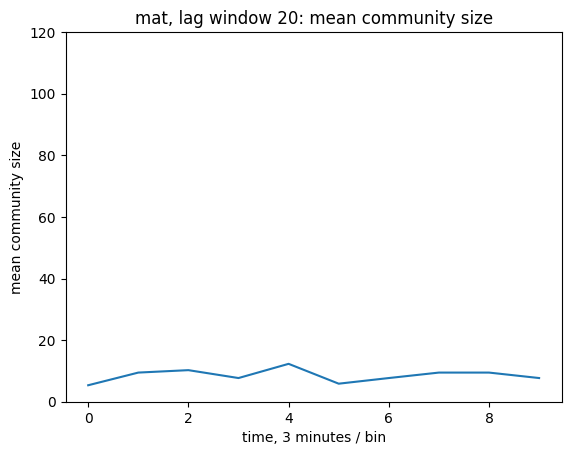

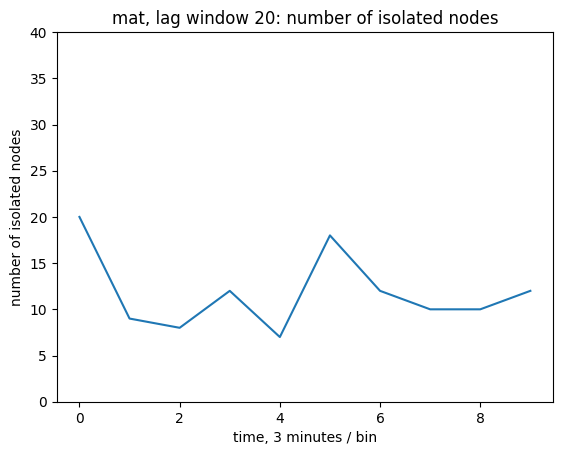

In [13]:
from scipy.stats import binom, linregress
from scipy.optimize import curve_fit
import matplotlib as mpl

# def curve(x, a, b, c):
#     return c * x**(a - 1) * np.exp(-b * x)

# def curve(x, a, b, c):
#     return c * x**(a - 1) * (1-x)**(b-1)

def curve(x, a, b, c):
    return c * np.exp(-(np.log(x) - a)**2 / b**2 / 2) / x

for lag in [10, 20]:
    for fn in ALL_FILES:
        with open(f'processed/{fn}_lag_window_{lag}.pkl', 'rb') as f:
            data = pickle.load(f)
            data_all, data = data['all'], data['slices']
        fn = fn.split('_')[2]
        # with open(f'processed/{fn}_lag_window_{lag}_shuffle.pkl', 'rb') as f:
        #     data_rnd = pickle.load(f)
        bins = np.linspace(0.0, 1.0, 100)
        histograms = np.array([np.histogram(d['corr'][abs(d['corr_idx_data']) > 2], bins=bins, density=True)[0] for d in data])
        mean_hist = (np.quantile(histograms, 0.95, 0) + np.quantile(histograms, 0.05, 0)) / 2.0
        stderr_hist = (np.quantile(histograms, 0.95, 0) - np.quantile(histograms, 0.05, 0)) / 2.0

        h0 = np.histogram(data_all['corr'][abs(data[0]['corr_idx_data']) > 2], bins=bins)[0]
        n = np.sum(abs(data_all['corr_idx_data']) > 2)
        distr = binom(n, h0 / n)
        lb, ub = distr.ppf(0.05), distr.ppf(0.95)
        mean_hist = h0 / n / np.diff(bins)
        stderr_hist = ((h0 - lb) / n / np.diff(bins), (ub - h0) / n / np.diff(bins))
        # , sigma=np.std(histograms, 0)[1:], absolute_sigma=True
        (a, b, c), pcov = curve_fit(curve, (bins[:-1] + np.diff(bins) / 2)[1:], np.mean(histograms, 0)[1:])
        print(pcov)
        # xs, ys = (bins[:-1] + np.diff(bins) / 2)[len(bins) // 2:], np.log(np.mean(histograms, 0))[len(bins) // 2:]
        # slope, intercept, r_value, p_value, std_err = linregress(xs, ys)

        # plt.bar(bins[:-1], mean_hist, width=np.diff(bins), align='edge', edgecolor='black', alpha=0.7)
        plt.errorbar(bins[:-1] + np.diff(bins) / 2, mean_hist, yerr=stderr_hist, fmt='none', ecolor='blue', capsize=2)
        plt.plot(bins[:-1] + np.diff(bins) / 2, curve(bins[:-1] + np.diff(bins) / 2, a, b, c), 'g-')
        # plt.plot(bins[:-1] + np.diff(bins) / 2, np.exp(slope * (bins[:-1] + np.diff(bins) / 2) + intercept), 'b-')
        # plt.hist(data['corr'][corr_mask], bins=bins)
        plt.title(f'{fn}, lag window {lag}: correlation coefficient distribution')
        plt.xlabel('correlation coefficient')
        plt.ylabel('normalized # of pairs')
        plt.yscale('log')
        plt.savefig(f'plots/{fn}_lag_window_{lag}.png')
        # print()
        plt.show()

        params = []
        param_errors = []
        for i in range(histograms.shape[0]):
            try:
                (a, b, c), pcov = curve_fit(curve, (bins[:-1] + np.diff(bins) / 2)[1:], histograms[i][1:])
            except Exception as e:
                print(e)
            params.append((a, b, c))
            param_errors.append(np.sqrt(np.diag(pcov)))
        plt.figure(figsize=(10, 20))
        for i in range(3):
            plt.subplot(3, 1, i + 1)
            plt.plot([p[i] for p in params])
            plt.errorbar(range(len(params)), [p[i] for p in params], yerr=[p[i] for p in param_errors], fmt='none', ecolor='blue', capsize=2)
            plt.title(f'{fn}, param {"abc"[i]}')
            plt.xlabel('time, 3 minutes / bin')
            plt.ylabel('fitted param value')
        plt.tight_layout()
        plt.savefig(f'plots/{fn}_lag_window_{lag}_params.png')
        plt.show()

        xs, ys = zip(*[(c, i) for i in range(len(data)) for c in data[i]['corr'][abs(data[i]['corr_idx_data']) > 2]])
        print(max(xs))
        plt.hist2d(ys, xs, bins=(len(data), 50), cmap='Blues', norm=mpl.colors.LogNorm(vmax=200000))
        plt.title(f'{fn}, lag window {lag}: correlation coefficient distribution')
        plt.ylim(0, 1)
        plt.xlabel('time, 3 minutes / bin')
        plt.ylabel('correlation coefficient')
        plt.colorbar()
        plt.savefig(f'plots/{fn}_lag_window_{lag}_2d.png')
        plt.show()

        xs, ys = zip(*[(c, i) for i in range(len(data)) for c in data[i]['C']])
        plt.hist2d(ys, xs, bins=(len(data), 50), cmap='Blues', norm=mpl.colors.LogNorm(vmax=100))
        plt.title(f'{fn}, lag window {lag}: clustering coefficient distribution')
        plt.ylim(0, 1)
        plt.xlabel('time, 3 minutes / bin')
        plt.ylabel('clustering coefficient')
        plt.colorbar()
        plt.savefig(f'plots/{fn}_lag_window_{lag}_2d_C.png')
        plt.show()

        xs, ys = zip(*[(c, i) for i in range(len(data)) for c in dict(data[i]['G'].degree()).values()])
        plt.hist2d(ys, xs, bins=(len(data), 50), cmap='Blues', norm=mpl.colors.LogNorm(vmax=100))
        plt.title(f'{fn} degree distribution, lag window {lag}')
        plt.xlabel('time, 3 minutes / bin')
        plt.ylabel('degree')
        plt.colorbar()
        plt.savefig(f'plots/{fn}_lag_window_{lag}_2d_degree.png')
        plt.show()

        communities = [algorithms.louvain(d['G']).communities for d in data]
        n_communities = [len(c) for c in communities]
        plt.plot(n_communities)
        plt.title(f'{fn}, lag window {lag}: number of communities')
        plt.ylim(0, 40)
        plt.xlabel('time, 3 minutes / bin')
        plt.ylabel('number of communities')
        plt.savefig(f'plots/{fn}_lag_window_{lag}_n_communities.png')
        plt.show()

        community_mean_sizes = [np.mean([len(x) for x in c]) for c in communities]
        plt.plot(community_mean_sizes)
        plt.title(f'{fn}, lag window {lag}: mean community size')
        plt.ylim(0, 120)
        plt.xlabel('time, 3 minutes / bin')
        plt.ylabel('mean community size')
        plt.savefig(f'plots/{fn}_lag_window_{lag}_mean_community_size.png')
        plt.show()

        isolated_nodes = [len([n for n in d['G'] if d['G'].degree(n) == 0]) for d in data]
        plt.plot(isolated_nodes)
        plt.title(f'{fn}, lag window {lag}: number of isolated nodes')
        plt.ylim(0, 40)
        plt.xlabel('time, 3 minutes / bin')
        plt.ylabel('number of isolated nodes')
        plt.savefig(f'plots/{fn}_lag_window_{lag}_isolated_nodes.png')
        plt.show()

